In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

Specify a input image file.

In [2]:
#image_file = 'bellpepper.jpg'
image_file = download_file('https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/python/predict_image/cat.jpg')
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

Download the ImageNet class file.

In [3]:
class_file = download_file('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')

Parse the class file and convert it to a Python dictionary.

In [4]:
import json
class_dict = json.load(open(class_file, 'r'))

Export the input image file to PyTorch tensor and normlize it in the ImageNet training image conditions.

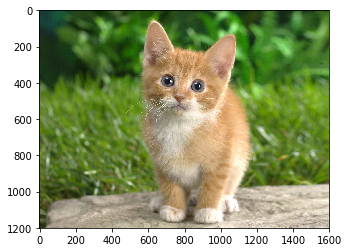

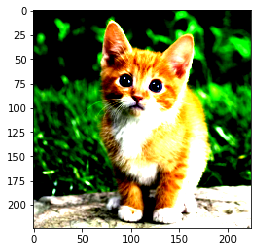

In [5]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

filtered_image = input_tensor.clone()
filtered_image = filtered_image.numpy().transpose((1, 2, 0))
filtered_image = np.float32(filtered_image)
filtered_image = np.clip(filtered_image, 0, 1)
plt.imshow(filtered_image)
plt.show()

Download the Torchvision AlexNet pre-traind model.

## Do inference by TensorRT

Prepare the explicit batch flag for TensorRT.

In [6]:
#onnx_file = 'pytorch_alexnet.onnx'
onnx_file = 'alexnet.onnx'
#onnx_file = 'mxnet_exported_resnet50.onnx'

In [7]:
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

Define a function to generate a TensorRT engine from a ONNX model.

In [8]:
import common
import trt_analyzer

TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)

def get_engine(onnx_file_path, engine_file_path=None):
    """Attempts to load a serialized engine if available, otherwise builds a new TensorRT engine and saves it."""
    def build_engine():
        """Takes an ONNX file and creates a TensorRT engine to run inference with"""
        with trt.Builder(TRT_LOGGER) as builder, builder.create_network(common.EXPLICIT_BATCH) as network, trt.OnnxParser(network, TRT_LOGGER) as parser, builder.create_builder_config() as config, trt.Runtime(TRT_LOGGER) as runtime:
            config.max_workspace_size = 1 << 29 # 512MiB
            builder.max_batch_size = 1
            # Parse model file
            if not os.path.exists(onnx_file_path):
                print('ONNX file {} not found.'.format(onnx_file_path))
                exit(0)
            print('Loading ONNX file from path {}...'.format(onnx_file_path))
            with open(onnx_file_path, 'rb') as model:
                print('Beginning ONNX file parsing')
                if not parser.parse(model.read()):
                    print ('ERROR: Failed to parse the ONNX file.')
                    for error in range(parser.num_errors):
                        print (parser.get_error(error))
                    return None
            network.get_input(0).shape = [1, 3, 224, 224]
            print('Completed parsing of ONNX file')
            # Get network info
            global net_dict
            net_dict = trt_analyzer.network_dict(network)
            print('Building an engine from file {}; this may take a while...'.format(onnx_file_path))
            plan = builder.build_serialized_network(network, config)
            engine = runtime.deserialize_cuda_engine(plan)
            print("Completed creating Engine")
            with open(engine_file_path, "wb") as f:
                f.write(engine.serialize())
            return engine

    if engine_file_path is None:
        f = os.path.splitext(os.path.basename(onnx_file_path))[0]
        engine_file_path = f + '.trt'
        
    if os.path.exists(engine_file_path):
        # If a serialized engine exists, use it instead of building an engine.
        print("Reading engine from file {}".format(engine_file_path))
        with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            return runtime.deserialize_cuda_engine(f.read())
    else:
        return build_engine()

Export the ONNX model to a TensorRT engine and do inference with it.

In [9]:
f = os.path.splitext(os.path.basename(onnx_file))[0]
engine_file = f + '.trt'
if os.path.exists(engine_file):
    os.remove(engine_file)

net_dict = None
with get_engine(onnx_file, engine_file) as engine, engine.create_execution_context() as context:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    inputs[0].host = input_batch.numpy()
    trt_outputs = common.do_inference_v2( \
        context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    idxlist = np.argsort(trt_outputs[0])[:-4:-1]
    for i in idxlist:
        print('{}:\t{}'.format(class_dict[str(i)][1], trt_outputs[0][i]))

Loading ONNX file from path alexnet.onnx...
Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine from file alexnet.onnx; this may take a while...
Completed creating Engine
Egyptian_cat:	18.67702293395996
tiger_cat:	17.634614944458008
tabby:	16.272857666015625


Print the TensorRT network.

In [10]:
import pandas as pd

pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,alexnet0_conv0_fwd,LayerType.CONVOLUTION,"(1, 3, 224, 224)","(1, 64, 55, 55)","ksz=(11, 11) maps=64 stride=(4, 4) pad=(0, 0)"
1,alexnet0_conv0_relu_fwd,LayerType.ACTIVATION,"(1, 64, 55, 55)","(1, 64, 55, 55)",type=ActivationType.RELU
2,alexnet0_pool0_fwd,LayerType.POOLING,"(1, 64, 55, 55)","(1, 64, 27, 27)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2..."
3,alexnet0_conv1_fwd,LayerType.CONVOLUTION,"(1, 64, 27, 27)","(1, 192, 27, 27)","ksz=(5, 5) maps=192 stride=(1, 1) pad=(0, 0)"
4,alexnet0_conv1_relu_fwd,LayerType.ACTIVATION,"(1, 192, 27, 27)","(1, 192, 27, 27)",type=ActivationType.RELU
5,alexnet0_pool1_fwd,LayerType.POOLING,"(1, 192, 27, 27)","(1, 192, 13, 13)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2..."
6,alexnet0_conv2_fwd,LayerType.CONVOLUTION,"(1, 192, 13, 13)","(1, 384, 13, 13)","ksz=(3, 3) maps=384 stride=(1, 1) pad=(0, 0)"
7,alexnet0_conv2_relu_fwd,LayerType.ACTIVATION,"(1, 384, 13, 13)","(1, 384, 13, 13)",type=ActivationType.RELU
8,alexnet0_conv3_fwd,LayerType.CONVOLUTION,"(1, 384, 13, 13)","(1, 256, 13, 13)","ksz=(3, 3) maps=256 stride=(1, 1) pad=(0, 0)"
9,alexnet0_conv3_relu_fwd,LayerType.ACTIVATION,"(1, 256, 13, 13)","(1, 256, 13, 13)",type=ActivationType.RELU


## Measure inference processing time

Define a decorator function to measure processing times.

In [11]:
import time
import functools

def processing_time(num_times, warmups=0):
    def _processing_time(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            for i in range(warmups):
                ret = func(*args, **kwargs)
            t0 = time.time()
            for i in range(num_times):
                ret = func(*args, **kwargs)
            t1 = time.time()
            print('Average a {0} times trial: {1:,f}sec'.format(num_times, (t1 - t0) / num_times))
            return ret
        return wrapper
    return _processing_time

Define a test function with the pocessing time measurement decorator.

In [12]:
@processing_time(100, 10)
def test_inference(context, bindings, inputs, outputs, stream):
    trt_outputs = common.do_inference_v2( \
        context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    return trt_outputs

Measure inference processing time.

In [13]:
with open(engine_file, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
    with runtime.deserialize_cuda_engine(f.read()) as engine, engine.create_execution_context() as context:
        inputs, outputs, bindings, stream = common.allocate_buffers(engine)
        inputs[0].host = input_batch.numpy()
        trt_outputs = test_inference( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        idxlist = np.argsort(trt_outputs[0])[:-4:-1]
        for i in idxlist:
            print('{}:\t{}'.format(class_dict[str(i)][1], trt_outputs[0][i]))

Average a 100 times trial: 0.006284sec
Egyptian_cat:	18.67702293395996
tiger_cat:	17.634614944458008
tabby:	16.272857666015625
